# Model diagnostics

It is recommended to read the tutorial [on the new models](./models_v2.ipynb) first.

PorePy is capable of running the multiphysics simulations of coupled processes in the mixed dimensional setting. That means in practice, that the model consists of multiple equations, each of which is defined on a set of subdomains or interfaces. The equations depend on model primary variables, which are defined on the corresponding subdomains and interfaces. The core of solution strategies to run the numerical simulation is solving a linear system of equations based on Jacobian matrix:
$$J_{ij}:=\frac{F_i}{x_j}$$
Here $F_i$ is any model equation after discretization, $x_j$ is any model primary variable in a discrete domain. The indices $i$ and $j$ run over the whole discrete computational domain and include all equations and variables in a model.

### Example:
Let's create a model including mass and energy balance with one fracture.

In [1]:
import numpy as np
import porepy as pp
from porepy.models.mass_and_energy_balance import MassAndEnergyBalance


class MyModel(MassAndEnergyBalance):
    def set_fracture_network(self) -> None:
        # Length scale:
        ls = 1 / self.units.m
        domain = {"xmin": 0, "xmax": 2 * ls, "ymin": 0, "ymax": 1 * ls}
        p = np.array([[0, 2], [0.5, 0.5]]) * ls
        e = np.array([[0], [1]])
        self.fracture_network = pp.FractureNetwork2d(p, e, domain)

    def mesh_arguments(self) -> dict:
        # Length scale:
        ls = 1 / self.units.m
        return {"mesh_size_frac": 0.2 * ls, "mesh_size_bound": 0.2 * ls}

    def bc_values_darcy(self, subdomains: list[pp.Grid]) -> pp.ad.Array:
        """Dirichlet value p=1 on the west boundary of the domain.

        Parameters:
            subdomains: List of subdomains on which to define boundary conditions.

        Returns:
            Array of boundary values.

        """
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, _, west, *_ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            # See section on scaling for explanation of the conversion.
            val_loc[west] = self.fluid.convert_units(1, "Pa")
            values.append(val_loc)
        return pp.wrap_as_ad_array(np.hstack(values), name="bc_values_darcy")

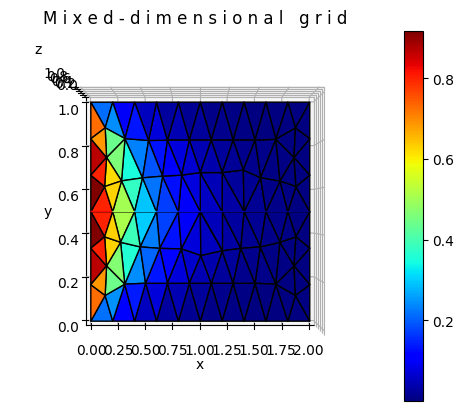

In [2]:
setup = MyModel({"domain_size": (10, 10)})
pp.run_time_dependent_model(setup, {})
pp.plot_grid(setup.mdg, cell_value=setup.pressure_variable)

The last assembled Jacobian can be accessed here:

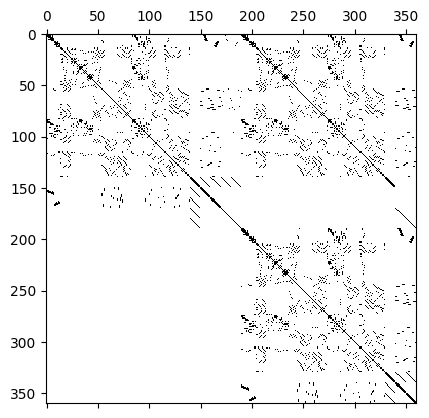

In [3]:
from matplotlib import pyplot as plt

jacobian, rhs = setup.linear_system

plt.spy(jacobian.toarray())

The image itself doesn't provide us with any useful information. However, studying the matrix is one way to debug the model you're working on.
The matrix consists of multiple blocks - the submatrices. Each block corresponds to the dependence of a specific equation on a specific variable. If there are multiple subdomains/interfaces, we can also divide each submatrix into grid-related blocks.

The list of equations used in this model:

In [4]:
for i, equation in enumerate(setup.equation_system.equations):
    print(f"{i}. {equation}")

0. energy_balance_equation
1. interface_fourier_flux_equation
2. interface_enthalpy_flux_equation
3. mass_balance_equation
4. interface_darcy_flux_equation


Here, one equation can be defined in multiple subdomains.

Now, we plot the list of variables. Note, that each variable corresponds to its own subdomain. That's why you'll see "temperature" and "pressure" twice - one of them is defined in the 2D subdomain, and the latter - in the 1D subdomain. 

In [5]:
for i, variable in enumerate(setup.equation_system.variables):
    print(f"{i}. {variable.name}")

0. temperature
1. temperature
2. interface_fourier_flux
3. interface_enthalpy_flux
4. pressure
5. pressure
6. interface_darcy_flux


## Diagnostics

The idea of the diagnostics is to monitor some integral value for each block. This value is called the "Condition number". Don't worry if you're not familiar with it. The things you need to know are that:
- it takes values in $[1, \infty]$.
- unity matrix has condition number = 1.
- degenerate matrices have condition number = $\infty$. 
- the smaller the condition number, the more accurately and easily we can solve a linear system numerically.

For more information, reference [Wikipedia](https://en.wikipedia.org/wiki/Condition_number).

We can compute the condition number for each submatrix of our Jacobian. A big condition number of a block can point out where to look for a bug or a reason for a performance decrease.

To run the diagnostics you need to add the diagnostics mixin to your model.

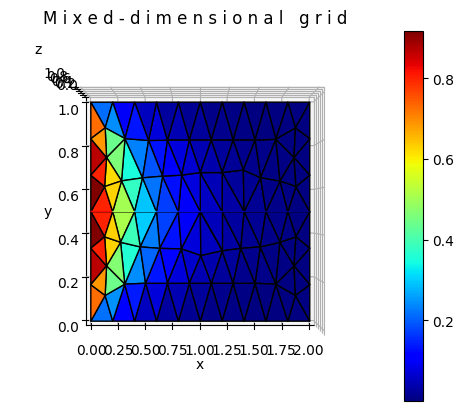

In [6]:
from porepy.viz.diagnostics_mixin import DiagnosticsMixin


class MandelWithDiagnostics(DiagnosticsMixin, MyModel):
    pass


setup = MandelWithDiagnostics({"domain_size": (10, 10)})
pp.run_time_dependent_model(setup, {})
pp.plot_grid(setup.mdg, cell_value=setup.pressure_variable)

The mixin provides a method `show_diagnostics`:

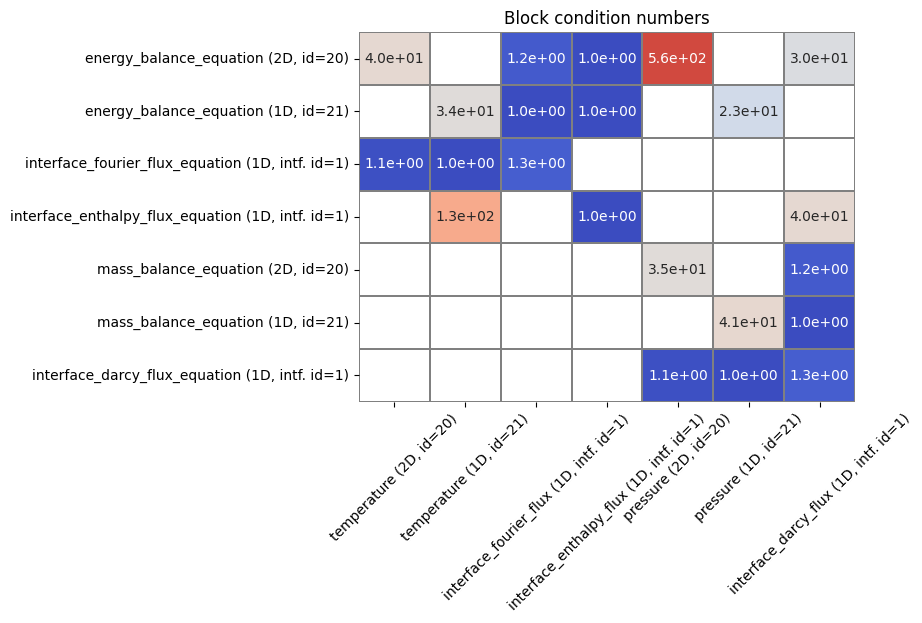

In [7]:
setup.show_diagnostics(is_plotting_condition_number=True, is_plotting_max=False)

Things to consider:
- Does your expectations of which equations depend on which variables (and on which grids) match what you see?
- Does any block have a much bigger condition value than the others? Is this expected?
- Maybe you should apply scaling to one of your model equations to decrease the condition number?

It is computationally expensive to compute the condition number for big matrices. In this case, you can use the simplified metric - the absolute maximum for each submatrix. It might provide less information about how bad is the block, but still a good thing to look at as a sanity check. If you need the condition number, it is recommended to decrease the model size. 

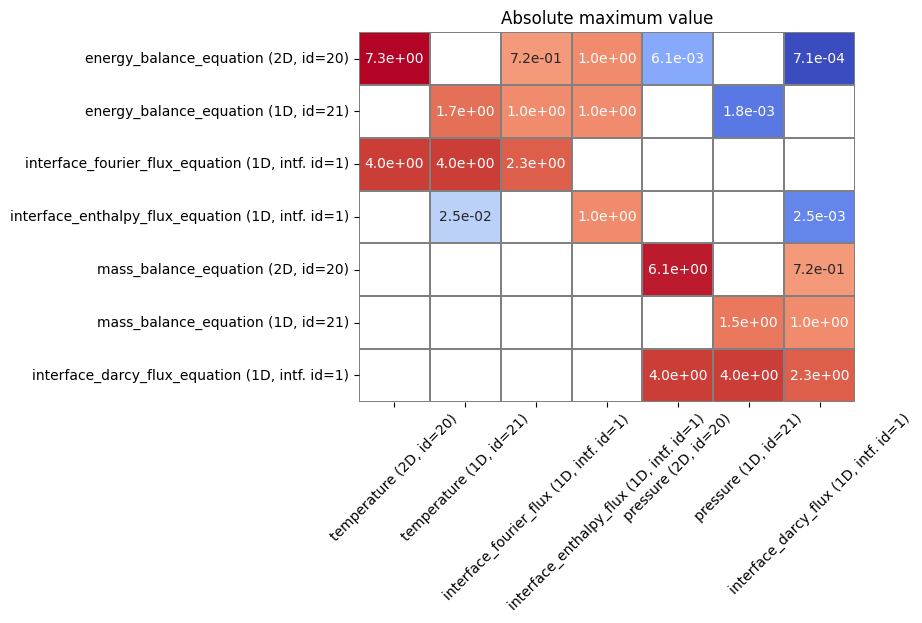

In [8]:
setup.show_diagnostics(is_plotting_condition_number=False, is_plotting_max=True)

# Grouping subdomains

If our model operates on a lot of subdomains, it might be difficult to visualize them all in one picture. Instead, we can gather the data from all subdomains into one cell. This is applied both to equations and variables.
To do so, we must call the method with an argument `grouping="subdomains"`.

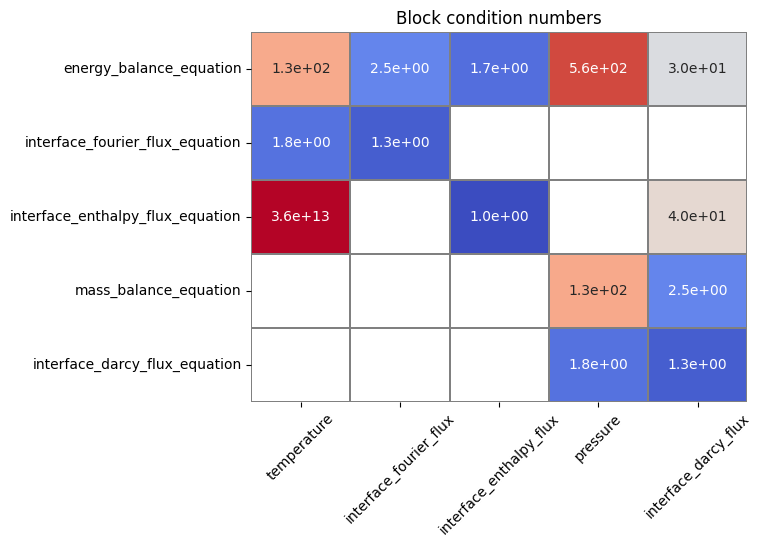

In [9]:
setup.show_diagnostics(
    is_plotting_condition_number=True, is_plotting_max=False, grouping="subdomains"
)

# What have we explored

The diagnostics mixin allows for visualizing properties of the discretized system of equations blocks in PorePy. It is useful to take these properties into account when developing and debugging a new model, or optimizing performance of an existing one.